In [1]:
using Images
using TestImages
using FileIO
using Colors
using ImageFeatures
using Formatting
# using Plots
using PyPlot
using DSP
using FixedPointNumbers
using Statistics

┌ Info: Recompiling stale cache file /home/luibo/.julia/compiled/v1.2/ImageFeatures/JMzL1.ji for ImageFeatures [92ff4b2b-8094-53d3-b29d-97f740f06cef]
└ @ Base loading.jl:1187
┌ Warning: Package Distributions does not have Test in its dependencies:
│ - If you have Distributions checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Distributions
└ Loading Test into Distributions from project dependency, future warnings for Distributions are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for ImageFeatures [92ff4b2b-8094-53d3-b29d-97f740f06cef]
│   exception = ErrorException("Required dependency Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] failed to load from a cache file.")
└ @ Base loading.jl:972
┌ Info: Recompiling stale cache file /home/luibo/.julia/compiled/v1.2/Distributions/xI

In [2]:
function backwardTransform(algo, M, P, outSize=nothing)
  M = inv(M)
  rows, cols = size(P)
  if outSize == nothing
    outSize = size(P)
  end
  out = zeros(eltype(P), outSize)

  for index in CartesianIndices(out)
    y, x = Tuple(index)
    sourceIndex = M * [x; y; 1]
    sourceIndex ./= sourceIndex[end]
    x1, y1 = round.(Int32, sourceIndex)
    if (x1 < 1 || y1 < 1 || x1 > cols || y1 > rows)
      continue
    end
    out[index] = P[y1, x1]
  end
  out
end

function createProjectiveMatrix(points)
  if length(points) != 4
    error("Not correct number of point")
  end

  A = zeros(Int64, 2*length(points), 8)
  B = zeros(Int64, 2*length(points), 1)
  for i in 1:length(points)
    x, y, x1, y1 = points[i]
    A[2*i - 1,:] = [x y 1 0 0 0 -x*x1 -x1*y]
    A[2*i,:] = [0 0 0 x y 1 -x*y1 -y*y1]
    B[2*i - 1] = x1
    B[2*i] = y1
  end

  H = vcat(A\B, 1)
  reshape(H, (3,3))'
end

function projectiveTransform(picture, points, outSize)
  M = createProjectiveMatrix(points)
  backwardTransform("zero", M, picture, outSize)
end

projectiveTransform (generic function with 1 method)

In [3]:
function hough(img)
  rows, cols = size(img)
  D = round(Int32, sqrt(rows ^ 2 + cols ^ 2))
  rhos = -D:1:D
  thetas = deg2rad.(-90:1:90)

  A = zeros(Int32, length(rhos), length(thetas))
  sins, coss = sin.(thetas), cos.(thetas)
  
  for idx in CartesianIndices(img)
    if img[idx] == 0
      # 0 or false
      continue
    end

    y, x = Tuple(idx)
    for thetaIdx in 1:length(thetas)
      rho = x * coss[thetaIdx] + y * sins[thetaIdx]
      rho = round(Int32, rho)
      A[rho + D, thetaIdx] += 1
    end
  end
  
  rowsA, colsA = size(A)
  for idx in CartesianIndices(A)
    y, x = Tuple(idx)
    if x == 1 || y == 1 || x == colsA || y == rowsA
      continue
    end
    C = A[idx]
    C1 = (C < A[y - 1, x - 1]) || (C < A[y - 1, x])
    C2 = (C < A[y - 1, x + 1]) || (C < A[y, x + 1])
    C3 = (C < A[y + 1, x + 1]) || (C < A[y + 1, x])
    C4 = (C < A[y + 1, x - 1]) || (C < A[y, x - 1])
    if C1 || C2 || C3 || C4
      A[idx] = 0
    end
  end

  A, rhos, thetas
end

hough (generic function with 1 method)

In [4]:
gaussian_kernel = [
  1 4 6 4 1
  4 16 24 16 4
  6 24 36 24 6
  4 16 24 16 4
  1 4 6 4 1
] ./ 256

sobel_x_kernel = [
  -1 0 1
  -2 0 2
  -1 0 1
]
sobel_y_kernel = rotl90(sobel_x_kernel)

3×3 Array{Int64,2}:
  1   2   1
  0   0   0
 -1  -2  -1

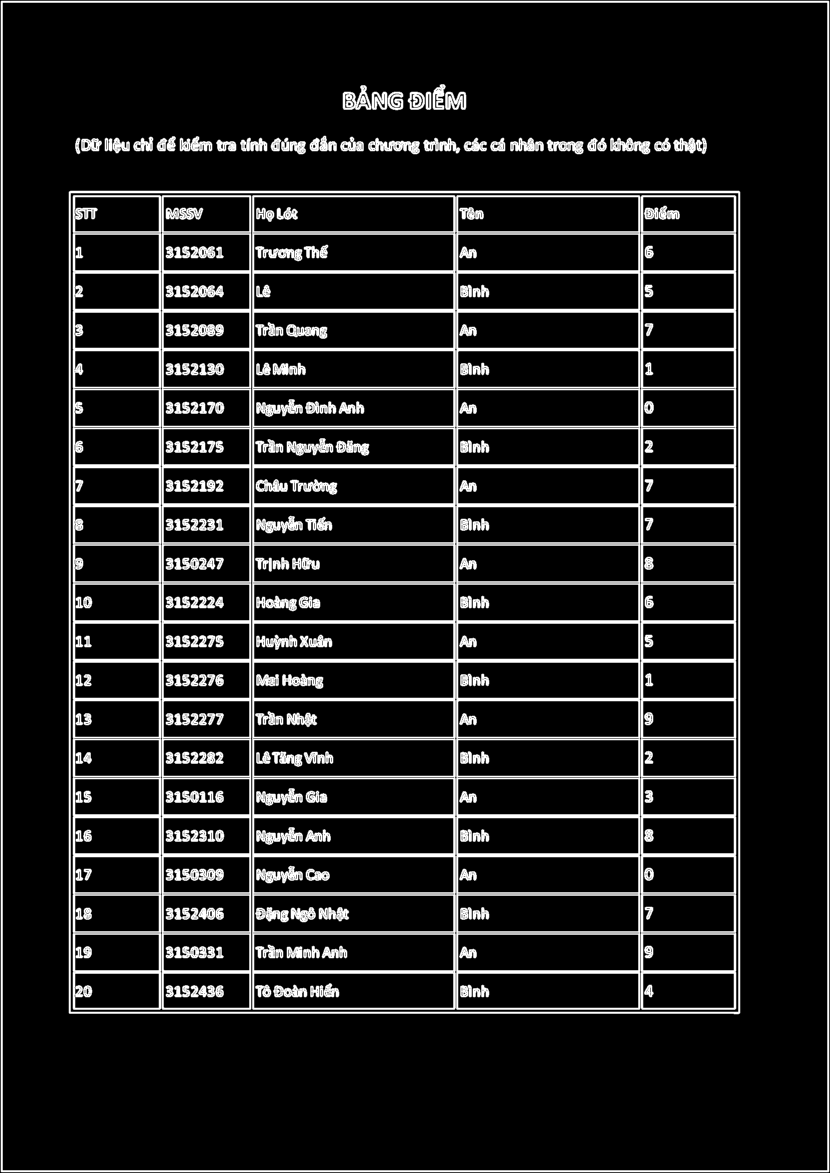

In [5]:
img_file = "IPCV-TestImage/Original Table-1.jpg"
rm("output/$(img_file)", recursive=true, force=true)
mkpath("output/$(img_file)")

img = load(img_file)
img_gray = Float64.(Gray.(img))
sobel_x_kernel = Float64.(sobel_x_kernel)
sobel_y_kernel = Float64.(sobel_y_kernel)

img_blur = conv2(img_gray, gaussian_kernel)
img_edge_x = conv2(img_blur, sobel_x_kernel)
img_edge_y = conv2(img_blur, sobel_y_kernel)

img_edge = round.(Int32, sqrt.((img_edge_x .^ 2) .+ (img_edge_y .^ 2)))
img_edge[img_edge .> 0] .= 1

# img_canny = canny(img, (Percentile(90), Percentile(10)))
# display(img_canny)


img_bool = zeros(Bool, size(img_edge))
img_bool[img_edge .> 0] .= true
display(Gray.(img_edge))
display()

In [6]:
acc, rhos, thetas = hough(img_edge)
for i in 1:50
  r_idx, t_idx = Tuple(argmax(acc))
  acc[r_idx, t_idx] = 0
  display((rhos[r_idx], rad2deg(thetas[t_idx])))
end

(2, 0.0)

(3, 0.0)

(4, 0.0)

(1654, 0.0)

(1655, 0.0)

(1656, 0.0)

(908, 0.0)

(914, 0.0)

(906, 0.0)

(325, 0.0)

(320, 0.0)

(500, 0.0)

(505, 0.0)

(1278, 0.0)

(498, 0.0)

(1282, 0.0)

(1284, 0.0)

(-2344, -90.0)

(-2343, -90.0)

(-2342, -90.0)

(-6, -90.0)

(-5, -90.0)

(-4, -90.0)

(2, 90.0)

(3, 90.0)

(4, 90.0)

(2340, 90.0)

(2341, 90.0)

(2342, 90.0)

(-2345, -90.0)

(-3, -90.0)

(1476, 0.0)

(1, 90.0)

(2343, 90.0)

(140, 0.0)

(138, 0.0)

(1478, 0.0)

(1469, 0.0)

(146, 0.0)

(147, 0.0)

(507, 0.0)

(1467, 0.0)

(910, 0.0)

(1471, 0.0)

(149, 0.0)

(-2027, -90.0)

(-2026, -90.0)

(-2025, -90.0)

(-387, -90.0)

(-386, -90.0)

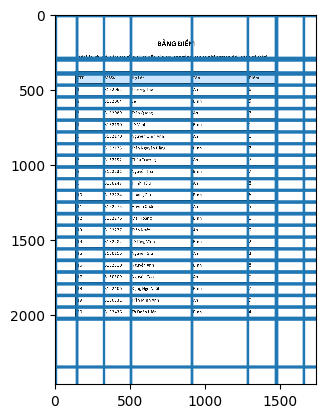

In [7]:
acc, rhos, thetas = hough(img_edge)
rows, cols = size(img)
my_dpi = 96

plt = PyPlot
# PyPlot.svg(true)
plt.figure(figsize=(cols/my_dpi, rows/my_dpi), dpi=my_dpi)

plot_img = plt.imread(img_file)
fig, ax = plt.subplots()
# fig = plt.figure(figsize=(cols/2, rows/2))
# fig.set_size_inches(cols,rows)

xs = []
ys = []

ax.imshow(plot_img)
while true
  r_idx, t_idx = Tuple(argmax(acc))
  if (acc[r_idx, t_idx] < 800)
    break
  end
  acc[r_idx, t_idx] = 0

  rho, theta = rhos[r_idx], thetas[t_idx]
  theta = rad2deg(theta)
  # display(theta)
  if (theta == 90 || theta == -90)
    y = rho / sind(theta)
    ax.axhline(y, linewidth=1)
    push!(ys,y)
  elseif (theta == 0)
    x = rho
    ax.axvline(x, linewidth=1)
    push!(xs,x)
  else
    continue
  end
end
savefig("output/$(img_file)/hough.svg", dpi=my_dpi * 20)

29-element Array{Any,1}:
    2
    3
    4
  138
  140
  146
  147
  149
  320
  325
  498
  500
  505
    ⋮
  914
 1278
 1282
 1284
 1467
 1469
 1471
 1476
 1478
 1654
 1655
 1656

360-element Array{Any,1}:
    1.0
    2.0
    3.0
    3.0
    4.0
    4.0
    5.0
    6.0
  283.0
  284.0
  285.0
  285.0
  286.0
    ⋮  
 2026.0
 2026.0
 2027.0
 2028.0
 2340.0
 2341.0
 2342.0
 2342.0
 2343.0
 2343.0
 2344.0
 2345.0

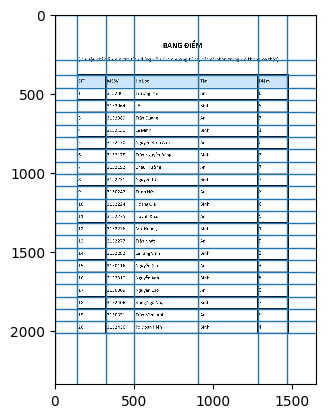

In [8]:
xs = sort(xs)
ys = sort(ys)

display(xs)
display(ys)

function get_arround(arr)
  out = Float64[]
  tmp = Float64[]
  last = 0
  for val in arr
    if last == 0
      last = val
      continue
    end
    push!(tmp, val)
    if abs(val - last) > 10
      # push!(out, round(Int32,mean(tmp)))
      push!(out, tmp[1])
      tmp = []
    end
    last = val
  end
  Int32.(out)
end

xss = get_arround(Float64.(xs))
yss = get_arround(Float64.(ys))
  
# display(xss)
# display(yss)
  
plt.figure(figsize=(cols/my_dpi, rows/my_dpi), dpi=my_dpi)
plot_img = plt.imread(img_file)
fig, ax = plt.subplots()
ax.imshow(plot_img)
for y in yss
  ax.axhline(y, linewidth=1)
end
for x in xss
  ax.axvline(x, linewidth=1)
end
savefig("output/$(img_file)/better_hough.svg", dpi=my_dpi * 20)

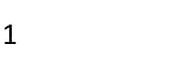

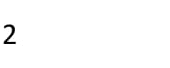

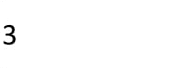

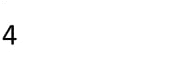

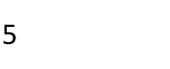

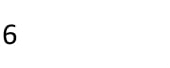

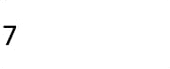

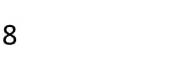

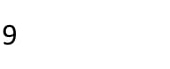

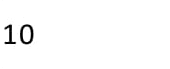

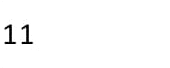

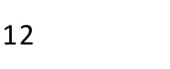

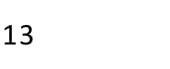

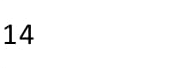

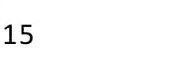

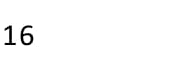

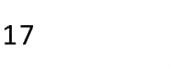

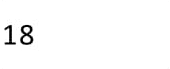

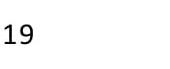

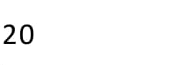

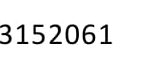

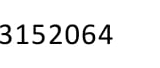

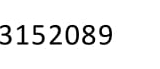

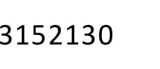

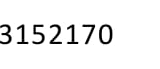

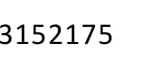

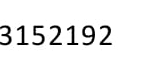

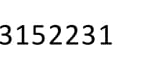

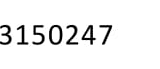

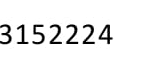

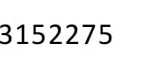

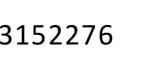

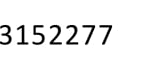

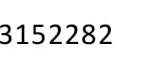

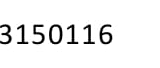

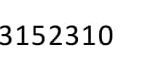

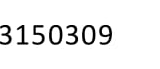

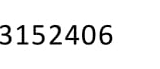

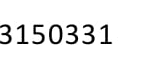

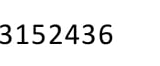

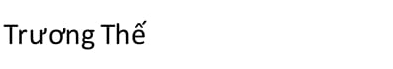

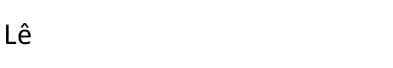

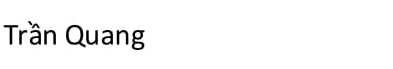

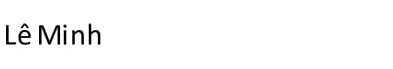

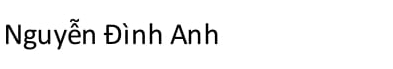

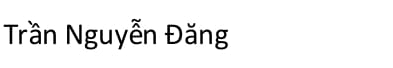

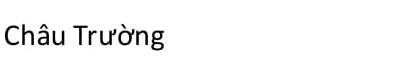

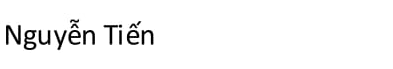

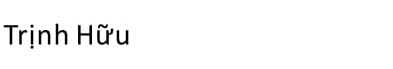

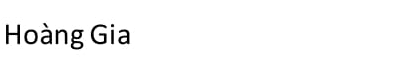

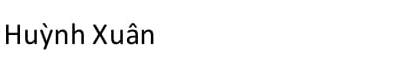

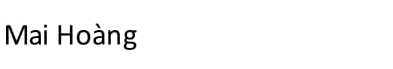

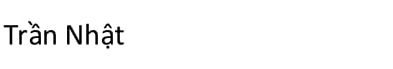

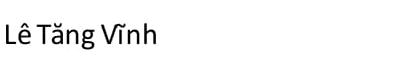

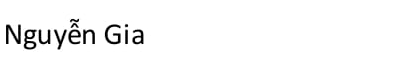

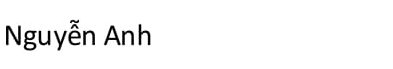

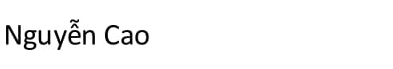

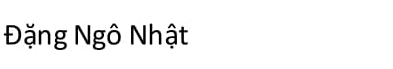

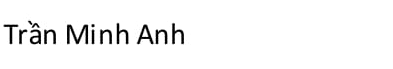

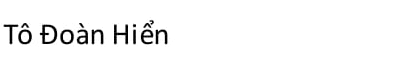

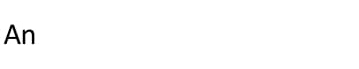

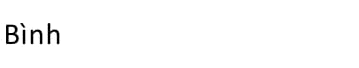

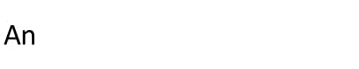

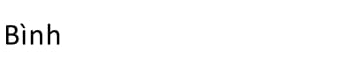

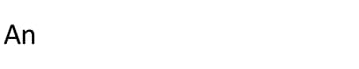

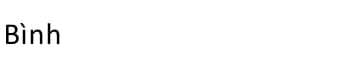

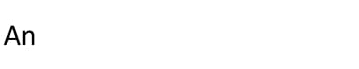

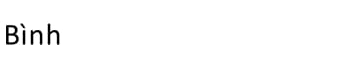

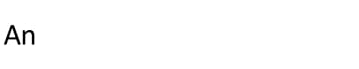

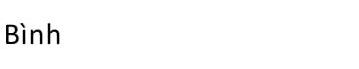

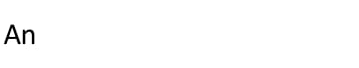

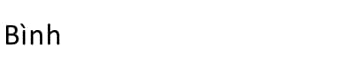

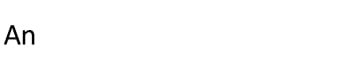

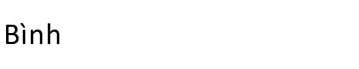

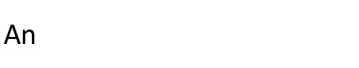

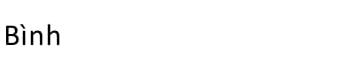

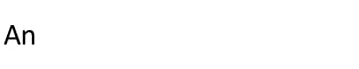

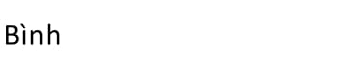

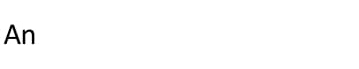

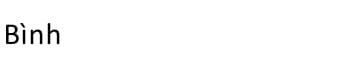

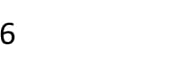

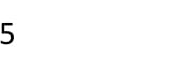

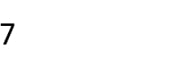

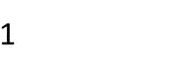

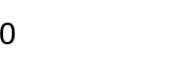

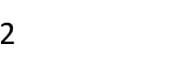

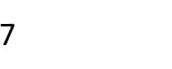

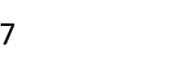

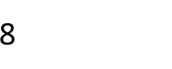

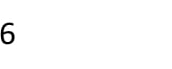

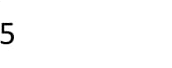

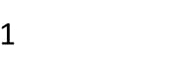

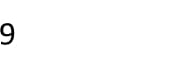

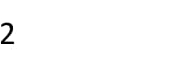

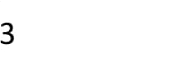

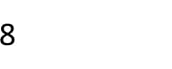

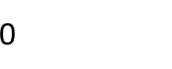

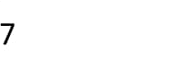

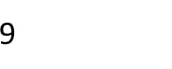

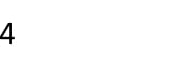

In [16]:
sub_imgs = []
for i in 3:length(xss)
  mkpath("output/$(img_file)/$(i-1)")
  # display((i, !(i in [3,4,5,7])))
#   if (!(i in [3,4,5,7,8]))
#     continue
#   end
  for j in 5:length(yss)
#     if j < 4
#       continue
#     end
    c = xss[i-1]+6:xss[i]-10
    r = yss[j-1]+5:yss[j]-5
    sub_img = img[r,c]
    push!(sub_imgs, sub_img)
    display(sub_img)
    # display("======================")
    save("output/$(img_file)/$(i-1)/$(j-1).png", sub_img)
  end
end

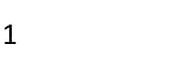

(11, 13)

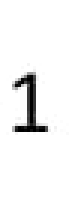

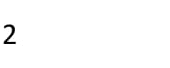

(13, 15)

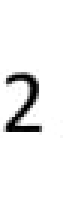

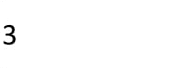

(13, 15)

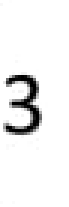

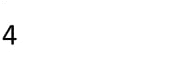

(13, 15)

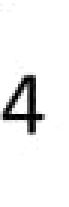

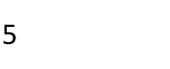

(13, 160)

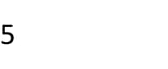

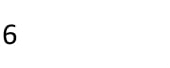

(11, 8)

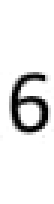

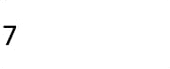

(11, 160)

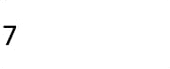

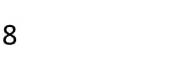

(11, 8)

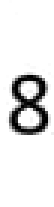

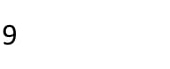

(15, 160)

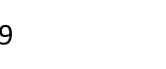

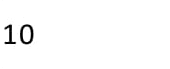

(11, 13)

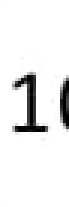

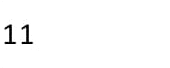

(11, 13)

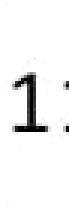

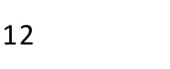

(11, 13)

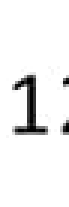

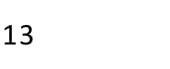

(11, 13)

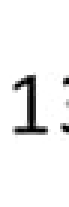

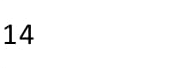

(11, 13)

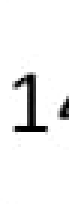

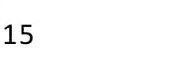

(11, 13)

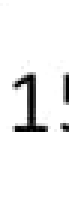

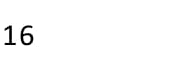

(11, 13)

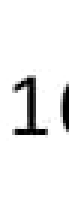

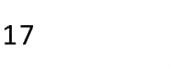

(11, 13)

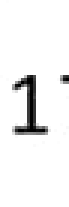

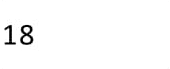

(11, 13)

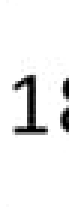

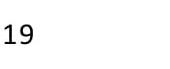

(11, 13)

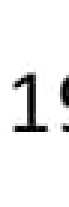

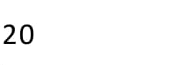

(13, 15)

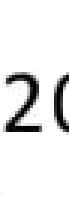

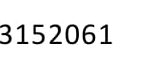

(11, 11)

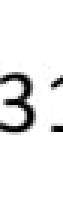

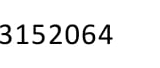

(11, 11)

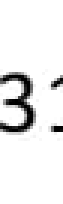

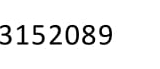

(11, 11)

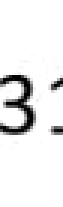

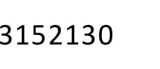

(11, 11)

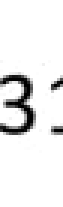

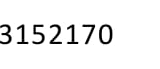

(11, 11)

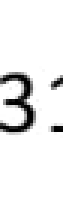

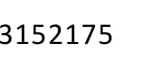

(11, 11)

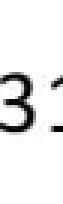

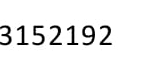

(11, 11)

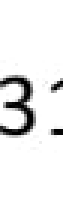

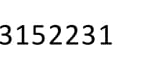

(11, 11)

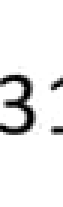

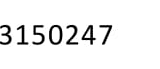

(11, 11)

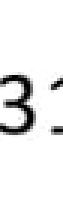

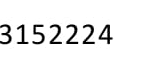

(11, 11)

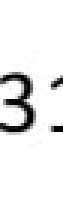

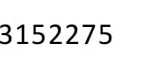

(11, 11)

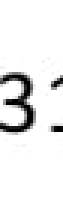

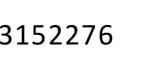

(11, 11)

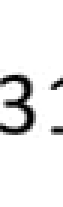

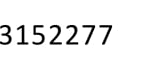

(11, 11)

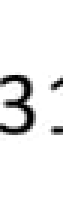

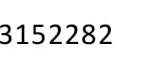

(11, 11)

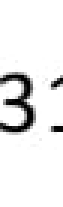

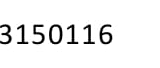

(11, 11)

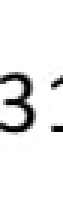

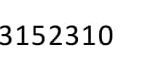

(11, 11)

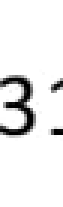

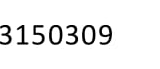

(11, 11)

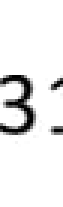

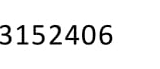

(11, 11)

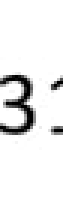

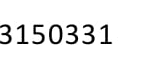

(11, 11)

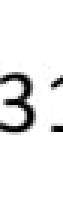

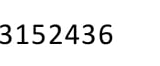

(11, 11)

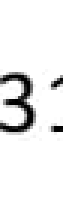

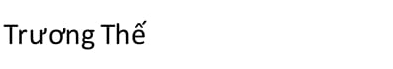

(21, 23)

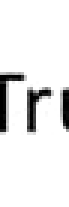

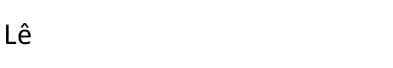

(11, 10)

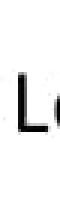

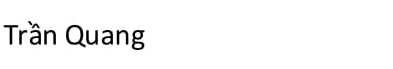

(40, 42)

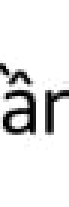

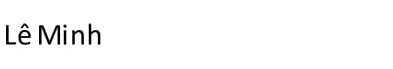

(11, 10)

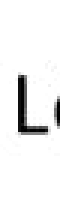

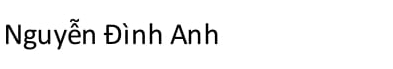

(11, 10)

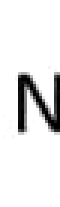

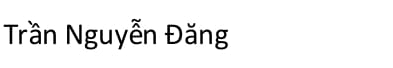

(21, 23)

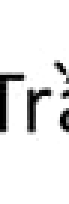

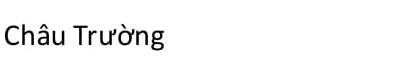

(24, 26)

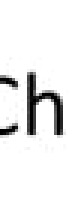

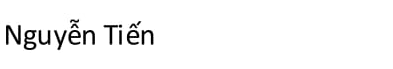

(11, 10)

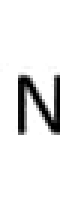

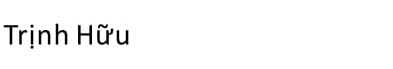

(21, 23)

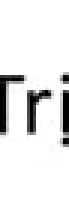

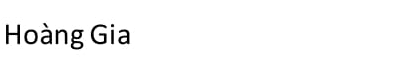

(11, 10)

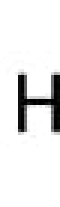

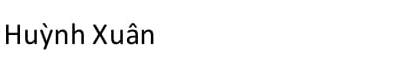

(11, 10)

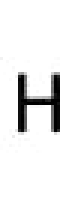

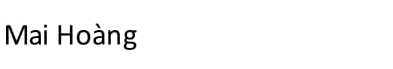

(11, 10)

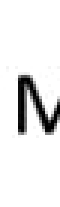

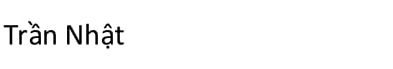

(40, 42)

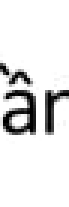

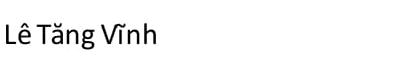

(11, 10)

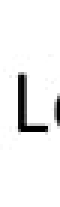

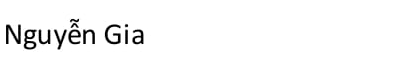

(11, 10)

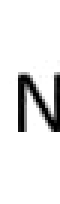

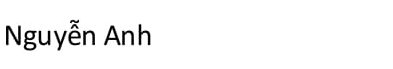

(11, 10)

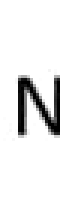

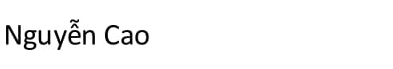

(11, 10)

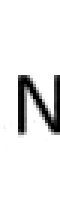

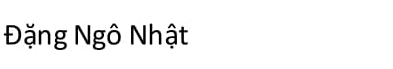

(11, 10)

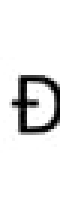

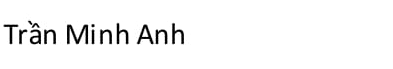

(21, 23)

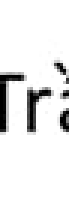

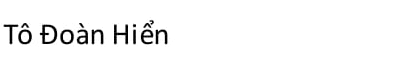

(44, 46)

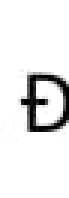

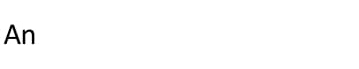

(34, 349)

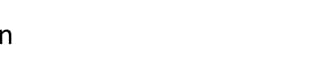

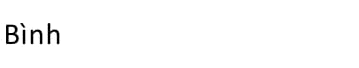

(11, 10)

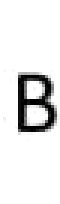

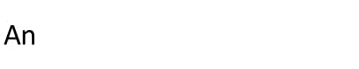

(34, 349)

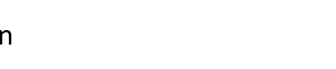

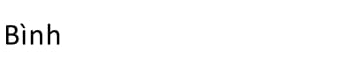

(11, 10)

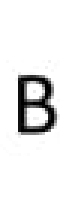

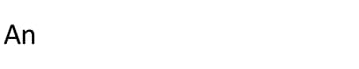

(34, 349)

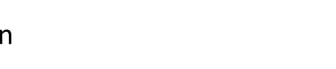

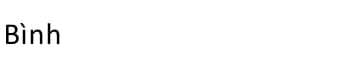

(11, 10)

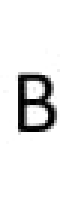

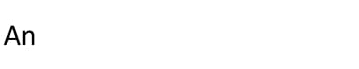

(34, 349)

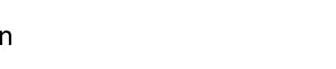

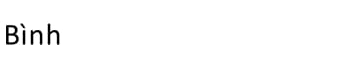

(11, 10)

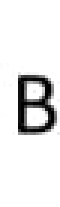

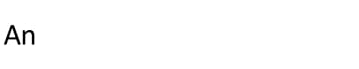

(34, 349)

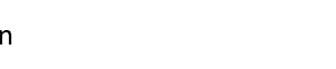

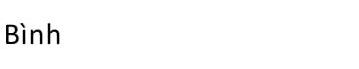

(11, 10)

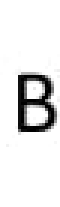

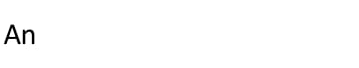

(34, 349)

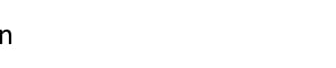

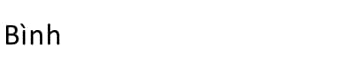

(11, 10)

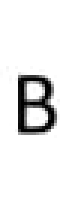

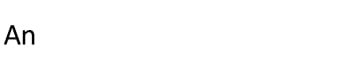

(34, 349)

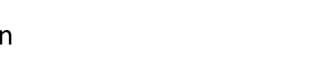

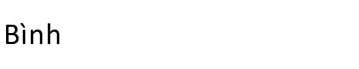

(11, 10)

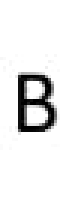

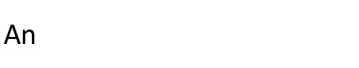

(34, 349)

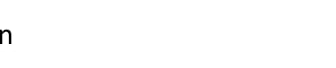

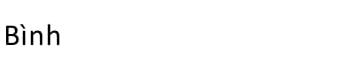

(11, 10)

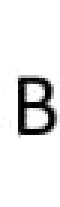

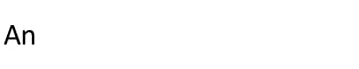

(34, 349)

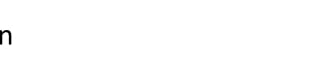

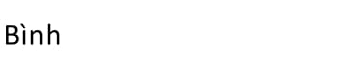

(11, 10)

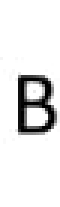

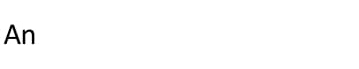

(34, 349)

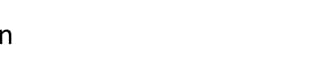

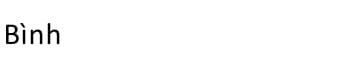

(11, 10)

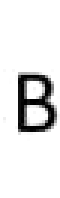

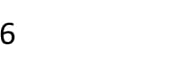

(11, 5)

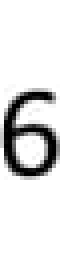

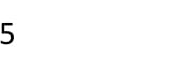

(11, 162)

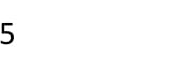

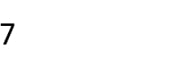

(11, 162)

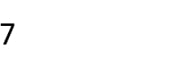

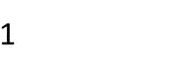

(11, 11)

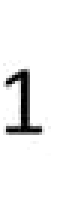

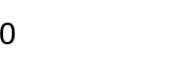

(11, 5)

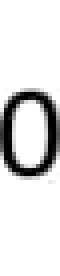

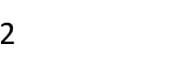

(11, 13)

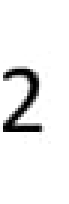

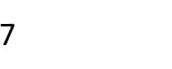

(11, 162)

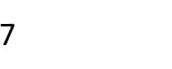

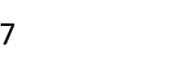

(11, 162)

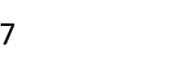

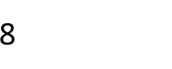

(12, 14)

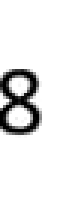

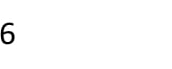

(11, 5)

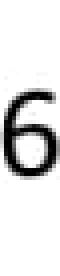

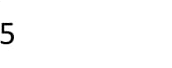

(11, 162)

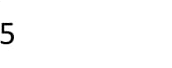

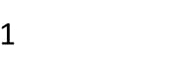

(11, 11)

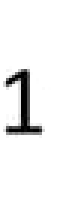

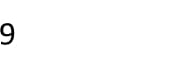

(11, 5)

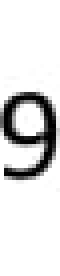

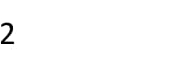

(11, 13)

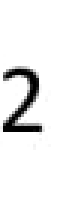

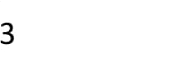

(13, 162)

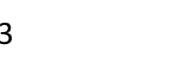

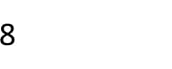

(12, 14)

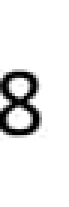

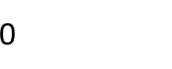

(11, 5)

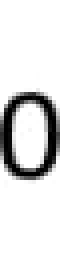

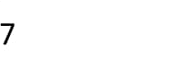

(11, 162)

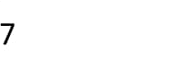

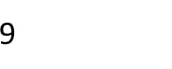

(11, 5)

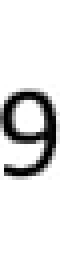

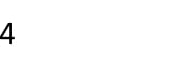

(11, 13)

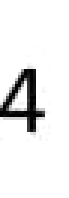

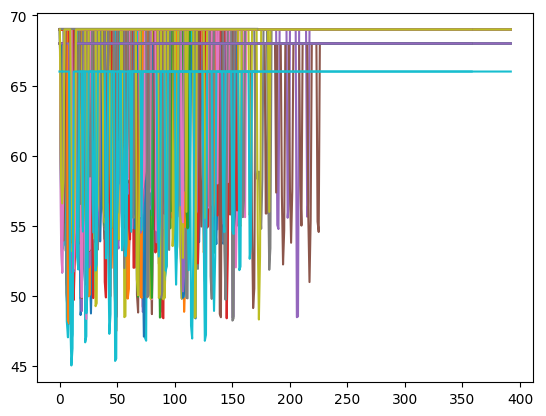

In [24]:
sub_img = sub_imgs[1]
for sub_img in sub_imgs
  display(sub_img)
  sub_img_f = Float64.(Gray.(sub_img))
  gray_point = vec(sum(sub_img_f, dims=1))
  gray_maximum = maximum(gray_point)
  gray_point[gray_point .< 10] .= 0
  gray_point[abs.(gray_point .- gray_maximum) .< 10] .= gray_maximum

  # display(gray_point)
  plt.plot(gray_point)

  digit_start = 1
  digit_end = length(gray_point)
  slide = 0
  window_size = 0

  for (index, value) in enumerate(gray_point)
    if value == 0 || value == gray_maximum
      if window_size > 2
        digit_end = index
        break
      elseif slide == 1
        slide = 0
      end
      continue
    end
    if slide == 0
      digit_start = index - 1
      slide = 1
      window_size = 1
    elseif index - digit_start > 1
      digit_start = index
      window_size = 1
    end
    window_size += 1
  end

  if (digit_start < 11)
    digit_start = 11
  end
  if (digit_end > length(gray_point) - 10)
    digit_end = length(gray_point) - 10
  end
  display((digit_start, digit_end))
  display(sub_img[:, digit_start-10:digit_end+10])
end